In [1]:
import pandas as pd
import numpy as np
import string
import re
import csv
from string import punctuation
from matplotlib import pyplot as plt
from statistics import variance as v, mean as m 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from ggplot import mtcars
from pandas import datetools
%matplotlib inline
import pandas
from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import ensemble
from IPython.display import Image  
# ! pip install pydotplus
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import GradientBoostingClassifier
import graphviz
from graphviz import Source
# ! pip install graphviz
%matplotlib inline
import seaborn as sns

C:\Users\Naga Raja Paidimarri\Anaconda3\lib\site-packages\ggplot\utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
C:\Users\Naga Raja Paidimarri\Anaconda3\lib\site-packages\ggplot\stats\smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
C:\Users\Naga Raja Paidimarri\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# ! pip install --upgrade pip

## PART 1: Data Cleaning

Both csv files are converted in to a data frame

In [3]:
training_df = pd.read_csv('income-training.csv')

In [4]:
testing_df = pd.read_csv('income-testing.csv')

In [430]:
training_df.shape[0]

24421

Checking which columns have null values in training_df

In [303]:
training_df.isnull().sum()

Age                 0
WorkClass        1384
FinalWeight         0
Education           0
EducationLvl        0
MaritalStatus       0
Occupation       1390
Relationship        0
Race                0
Sex                 0
CapitalGain         0
CapitalLoss         0
HoursPerWeek        0
NativeCountry     395
IncomeBracket       0
dtype: int64

we can see that only three columns have 'nan' values 'WorkClass', 'Occupation','NativeCountry'
First, we will create a new data frame which is the subset of the original training data frame that contains 'nan' values


In [304]:
training_df["WorkClass"].value_counts()

Private             17002
Self-emp-not-inc     1910
Local-gov            1574
State-gov             978
Self-emp-inc          844
Federal-gov           712
Without-pay            11
Never-worked            6
Name: WorkClass, dtype: int64

In [305]:
training_df["Occupation"].value_counts()

Exec-managerial      3102
Prof-specialty       3099
Craft-repair         3062
Adm-clerical         2833
Sales                2738
Other-service        2449
Machine-op-inspct    1499
Transport-moving     1151
Handlers-cleaners    1062
Tech-support          723
Farming-fishing       710
Protective-serv       480
Priv-house-serv       115
Armed-Forces            8
Name: Occupation, dtype: int64

In [306]:
training_df["NativeCountry"].value_counts()

United-States                 21978
Mexico                          485
Philippines                     146
Germany                          96
Puerto-Rico                      90
Canada                           82
El-Salvador                      80
India                            73
Cuba                             71
England                          59
South                            58
China                            56
Jamaica                          53
Japan                            46
Poland                           46
Guatemala                        44
Dominican-Republic               44
Vietnam                          43
Haiti                            43
Italy                            43
Columbia                         39
Greece                           31
Taiwan                           31
Iran                             31
Portugal                         27
Peru                             21
France                           20
Nicaragua                   

if we look in to value counts we can clearly say that for "WorkClass" and "NativeCountry" the columns are mostly dominated by a single
value so it makes sense to replace them with mode but for "Occupation" it is distributed. If we replace "Workclass" column nan values 
with mode "private" the accuracy would be (17002 / 24421) 69% only. so I have decided not to simply replace all the nan values with
their respective column mode instead I want to predict the nan values using a classification model which takes inputs as "all other columns including
the income column" except these threee columns which has nan values

In [5]:
df1 = training_df[training_df.WorkClass.isnull()] 
df2 = training_df[training_df.Occupation.isnull()] 
df3 = training_df[training_df.NativeCountry.isnull()] 
new_df_test = pd.concat([df1,df2,df3],axis =0)

new_df_test contains all the columns which have atleast one nan value

In [6]:
new_df_train = pd.concat([training_df, new_df_test]).drop_duplicates(keep=False)

In [433]:
new_df_train.head()

,Age,WorkClass,FinalWeight,Education,EducationLvl,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,IncomeBracket
0,42,State-gov,179151,Some-college,10,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,40,United-States,<50K
1,28,Private,68021,Some-college,10,Never-married,Other-service,Not-in-family,White,Female,0,0,30,United-States,<50K
2,24,Private,233499,Some-college,10,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,50-100K
3,32,Self-emp-not-inc,168782,9th,5,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,32,United-States,<50K
4,55,Self-emp-not-inc,105582,Masters,14,Married-civ-spouse,Sales,Husband,White,Male,2228,0,50,United-States,<50K


new_df_train is obtained by removing the new_df_test columns from original data frame, now new_df_train has all columns without nan values and 
new_df_test has all columns with nan values

In [7]:
x = new_df_train.copy()

x is created for future use

In [8]:
new_df_test = new_df_test.drop_duplicates()

In [312]:
new_df_train.isnull().sum()

Age              0
WorkClass        0
FinalWeight      0
Education        0
EducationLvl     0
MaritalStatus    0
Occupation       0
Relationship     0
Race             0
Sex              0
CapitalGain      0
CapitalLoss      0
HoursPerWeek     0
NativeCountry    0
IncomeBracket    0
dtype: int64

we can see that new_df_train has no nan values

#### In order to predict nan values I have used random classifier algorithm
#### we can also replace it by mode but if we can predict those values using any classification algorithm with default parameters still we get more accuracy than simply using mode.
#### here, I used random classififer because it is fast and also can predicit mulitple classification better than logistic regression

In [9]:
new_df_test = new_df_test.drop(['WorkClass','Occupation', 'NativeCountry'],1)

I am droppping these columns because they interfere in classification as they have nan values

In [10]:
le = preprocessing.LabelEncoder()
for col_name in new_df_train.columns:
    if(new_df_train[col_name].dtype == 'object'):
        le.fit(new_df_train[col_name])
        new_df_train[col_name] = le.transform(new_df_train[col_name]) 

In [11]:
le = preprocessing.LabelEncoder()
for col_name in new_df_test.columns:
    if(new_df_test[col_name].dtype == 'object'):
        le.fit(new_df_test[col_name])
        new_df_test[col_name] = le.transform(new_df_test[col_name]) 

I converted all categorical values in to numbers using 'Label Encoder'

In [12]:
X_train = new_df_train.drop(['WorkClass','Occupation', 'NativeCountry'],1)
y_train = new_df_train.WorkClass
X_test = new_df_test


First, I will predict the nan values for "workclass" so my y_train is only "work class", will repeat the proceedure two more times

In [13]:
indexlist = new_df_test.index.values

this index list keeps tracks of index values correspondin to nan values, I will use this to replace the y_pred values in to original training_df

rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)
y_pred_Train = rfc.predict(X_train)
print('Accuracy: %.4f' % accuracy_score(y_train, y_pred_Train))

the accuracy of the mdoel is 97% which is way better than 69%, and this not computationally expensive because I am using random classifier with 
default parameters no hypertuning, it is better always to the model method first and check if the accuracy is greater than mode. 

In [14]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)
y_pred_Train = rfc.predict(X_train)
print('Accuracy: %.4f' % accuracy_score(y_train, y_pred_Train))

Accuracy: 0.9765


In [608]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 703, 1: 1555, 2: 16692, 3: 825, 4: 1880, 5: 969, 6: 11}

In [609]:
unique, counts = np.unique(y_pred, return_counts=True)
dict(zip(unique, counts))

{0: 16, 1: 50, 2: 1549, 3: 11, 4: 120, 5: 20}

this is for checking if random classifier is predicting more than 2 classes

In [15]:
le = preprocessing.LabelEncoder()
le.fit(x['WorkClass'])
y_pred_inverse = le.inverse_transform(y_pred)

I converting the label encoder numbers to categorical classe using inverse transfor

In [199]:
# unique, counts = np.unique(y_pred_inverse, return_counts=True)
# dict(zip(unique, counts))

In [16]:
for i in range (0,len(indexlist)):
    training_df.iloc[indexlist[i],1] = y_pred_inverse[i]

Now I used the predicted values to replace in the orignal data frame, I used the indexlist I prepared earlier

In [17]:
y_train = new_df_train.Occupation

rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)
y_pred_Train = rfc.predict(X_train)
print('Accuracy: %.4f' % accuracy_score(y_train, y_pred_Train))

le = preprocessing.LabelEncoder()
le.fit(x['Occupation'])
y_pred_inverse = le.inverse_transform(y_pred)

for i in range (0,len(indexlist)):
    training_df.iloc[indexlist[i],6] = y_pred_inverse[i]

Accuracy: 0.9712


repeated the same procedure for "Occupation"

In [18]:
y_train = new_df_train.NativeCountry

rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)
y_pred_Train = rfc.predict(X_train)
print('Accuracy: %.4f' % accuracy_score(y_train, y_pred_Train))

le = preprocessing.LabelEncoder()
le.fit(x['NativeCountry'])
y_pred_inverse = le.inverse_transform(y_pred)

for i in range (0,len(indexlist)):
    training_df.iloc[indexlist[i],13] = y_pred_inverse[i]

Accuracy: 0.9937


Repeated the same procedure for NativeCountry

In [332]:
# training_df.isnull().sum()

In [19]:
training_df = training_df.fillna({"WorkClass": "Private"})

In [20]:
training_df = training_df.fillna({"Occupation": "Exec-managerial"})

In [331]:
training_df.isnull().sum()

Age              0
WorkClass        0
FinalWeight      0
Education        0
EducationLvl     0
MaritalStatus    0
Occupation       0
Relationship     0
Race             0
Sex              0
CapitalGain      0
CapitalLoss      0
HoursPerWeek     0
NativeCountry    0
IncomeBracket    0
dtype: int64

we can see that now the training_df has no nan values

In [21]:
unencodedtraining = training_df.copy()

unencodedtraining will be used in exploratory analysis

In [400]:
unencodedtraining.head()

,Age,WorkClass,FinalWeight,Education,EducationLvl,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,IncomeBracket
0,42,State-gov,179151,Some-college,10,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,40,United-States,<50K
1,28,Private,68021,Some-college,10,Never-married,Other-service,Not-in-family,White,Female,0,0,30,United-States,<50K
2,24,Private,233499,Some-college,10,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,50-100K
3,32,Self-emp-not-inc,168782,9th,5,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,32,United-States,<50K
4,55,Self-emp-not-inc,105582,Masters,14,Married-civ-spouse,Sales,Husband,White,Male,2228,0,50,United-States,<50K


In [22]:
le = preprocessing.LabelEncoder()
for col_name in new_df_train.columns:
    if(training_df[col_name].dtype == 'object'):
        le.fit(training_df[col_name])
        training_df[col_name] = le.transform(training_df[col_name]) 

In [618]:
training_df.head()

,Age,WorkClass,FinalWeight,Education,EducationLvl,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,IncomeBracket
0,42,5,179151,15,10,2,4,0,4,1,0,0,40,38,1
1,28,2,68021,15,10,4,7,1,4,0,0,0,30,38,1
2,24,2,233499,15,10,2,13,0,4,1,0,0,40,38,0
3,32,4,168782,6,5,2,2,0,4,1,0,0,32,38,1
4,55,4,105582,12,14,2,11,0,4,1,2228,0,50,38,1


#### Encoding is done using label encoder. While performing classification I will use the standard scalar to standardize all the values.
#### I can also use dummies but using dummies increases the number of features this has many disadvantages.
#### As number of features increases the algorithm computationally becomes very complex, I illustrated this with an example in the bottom

## PART 2 : Exploratory Data Analysis

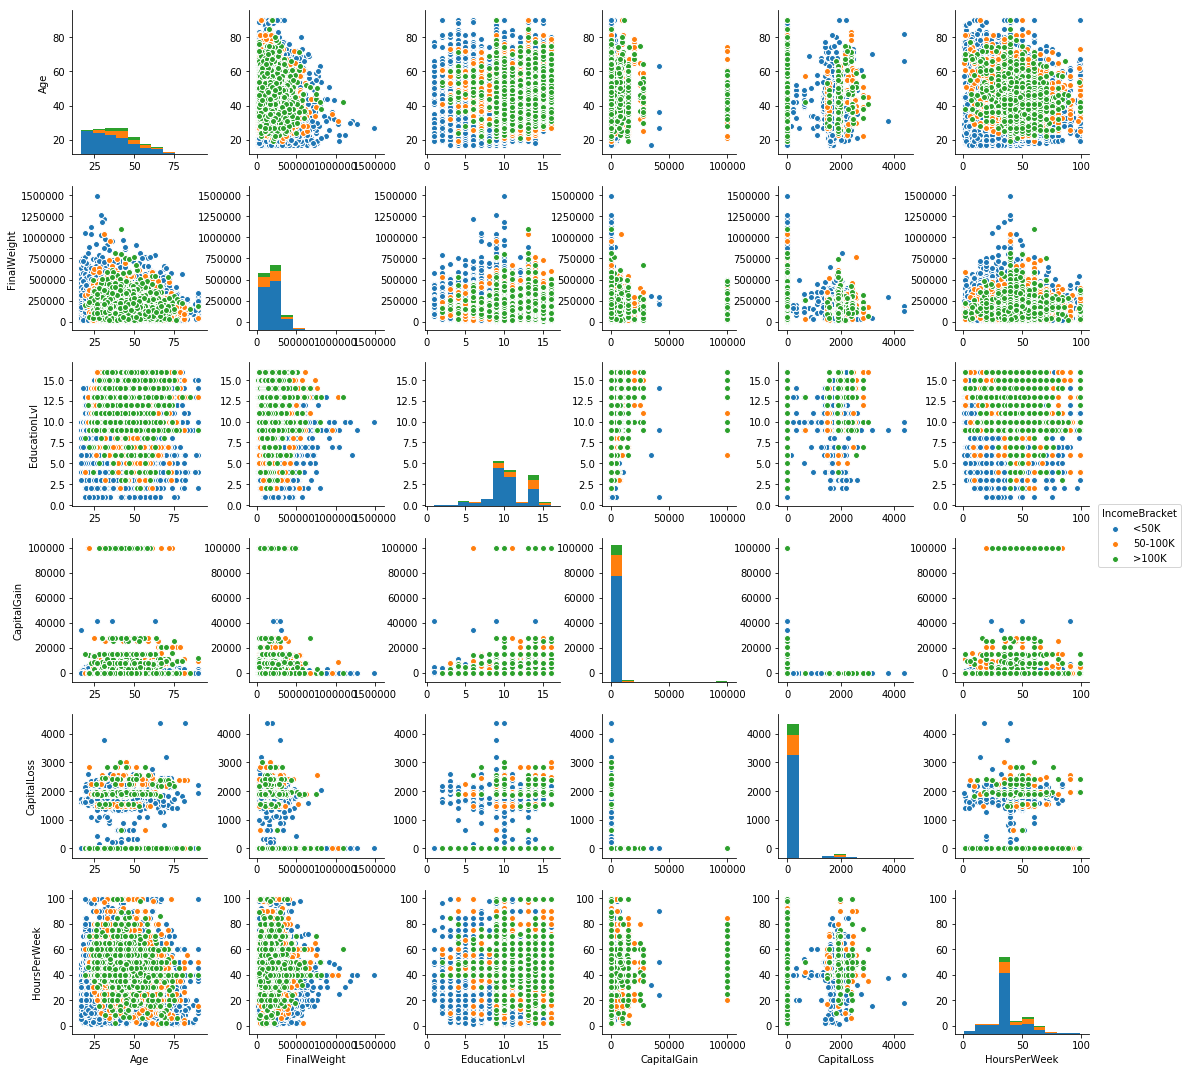

In [351]:
plt.figure()
sns.pairplot(unencodedtraining, hue='IncomeBracket')

### Pair plots help us in indentifying the correlations between all the features

pair plots for encoded data, as most of them are categorical it only gave ouput for numerical value columns

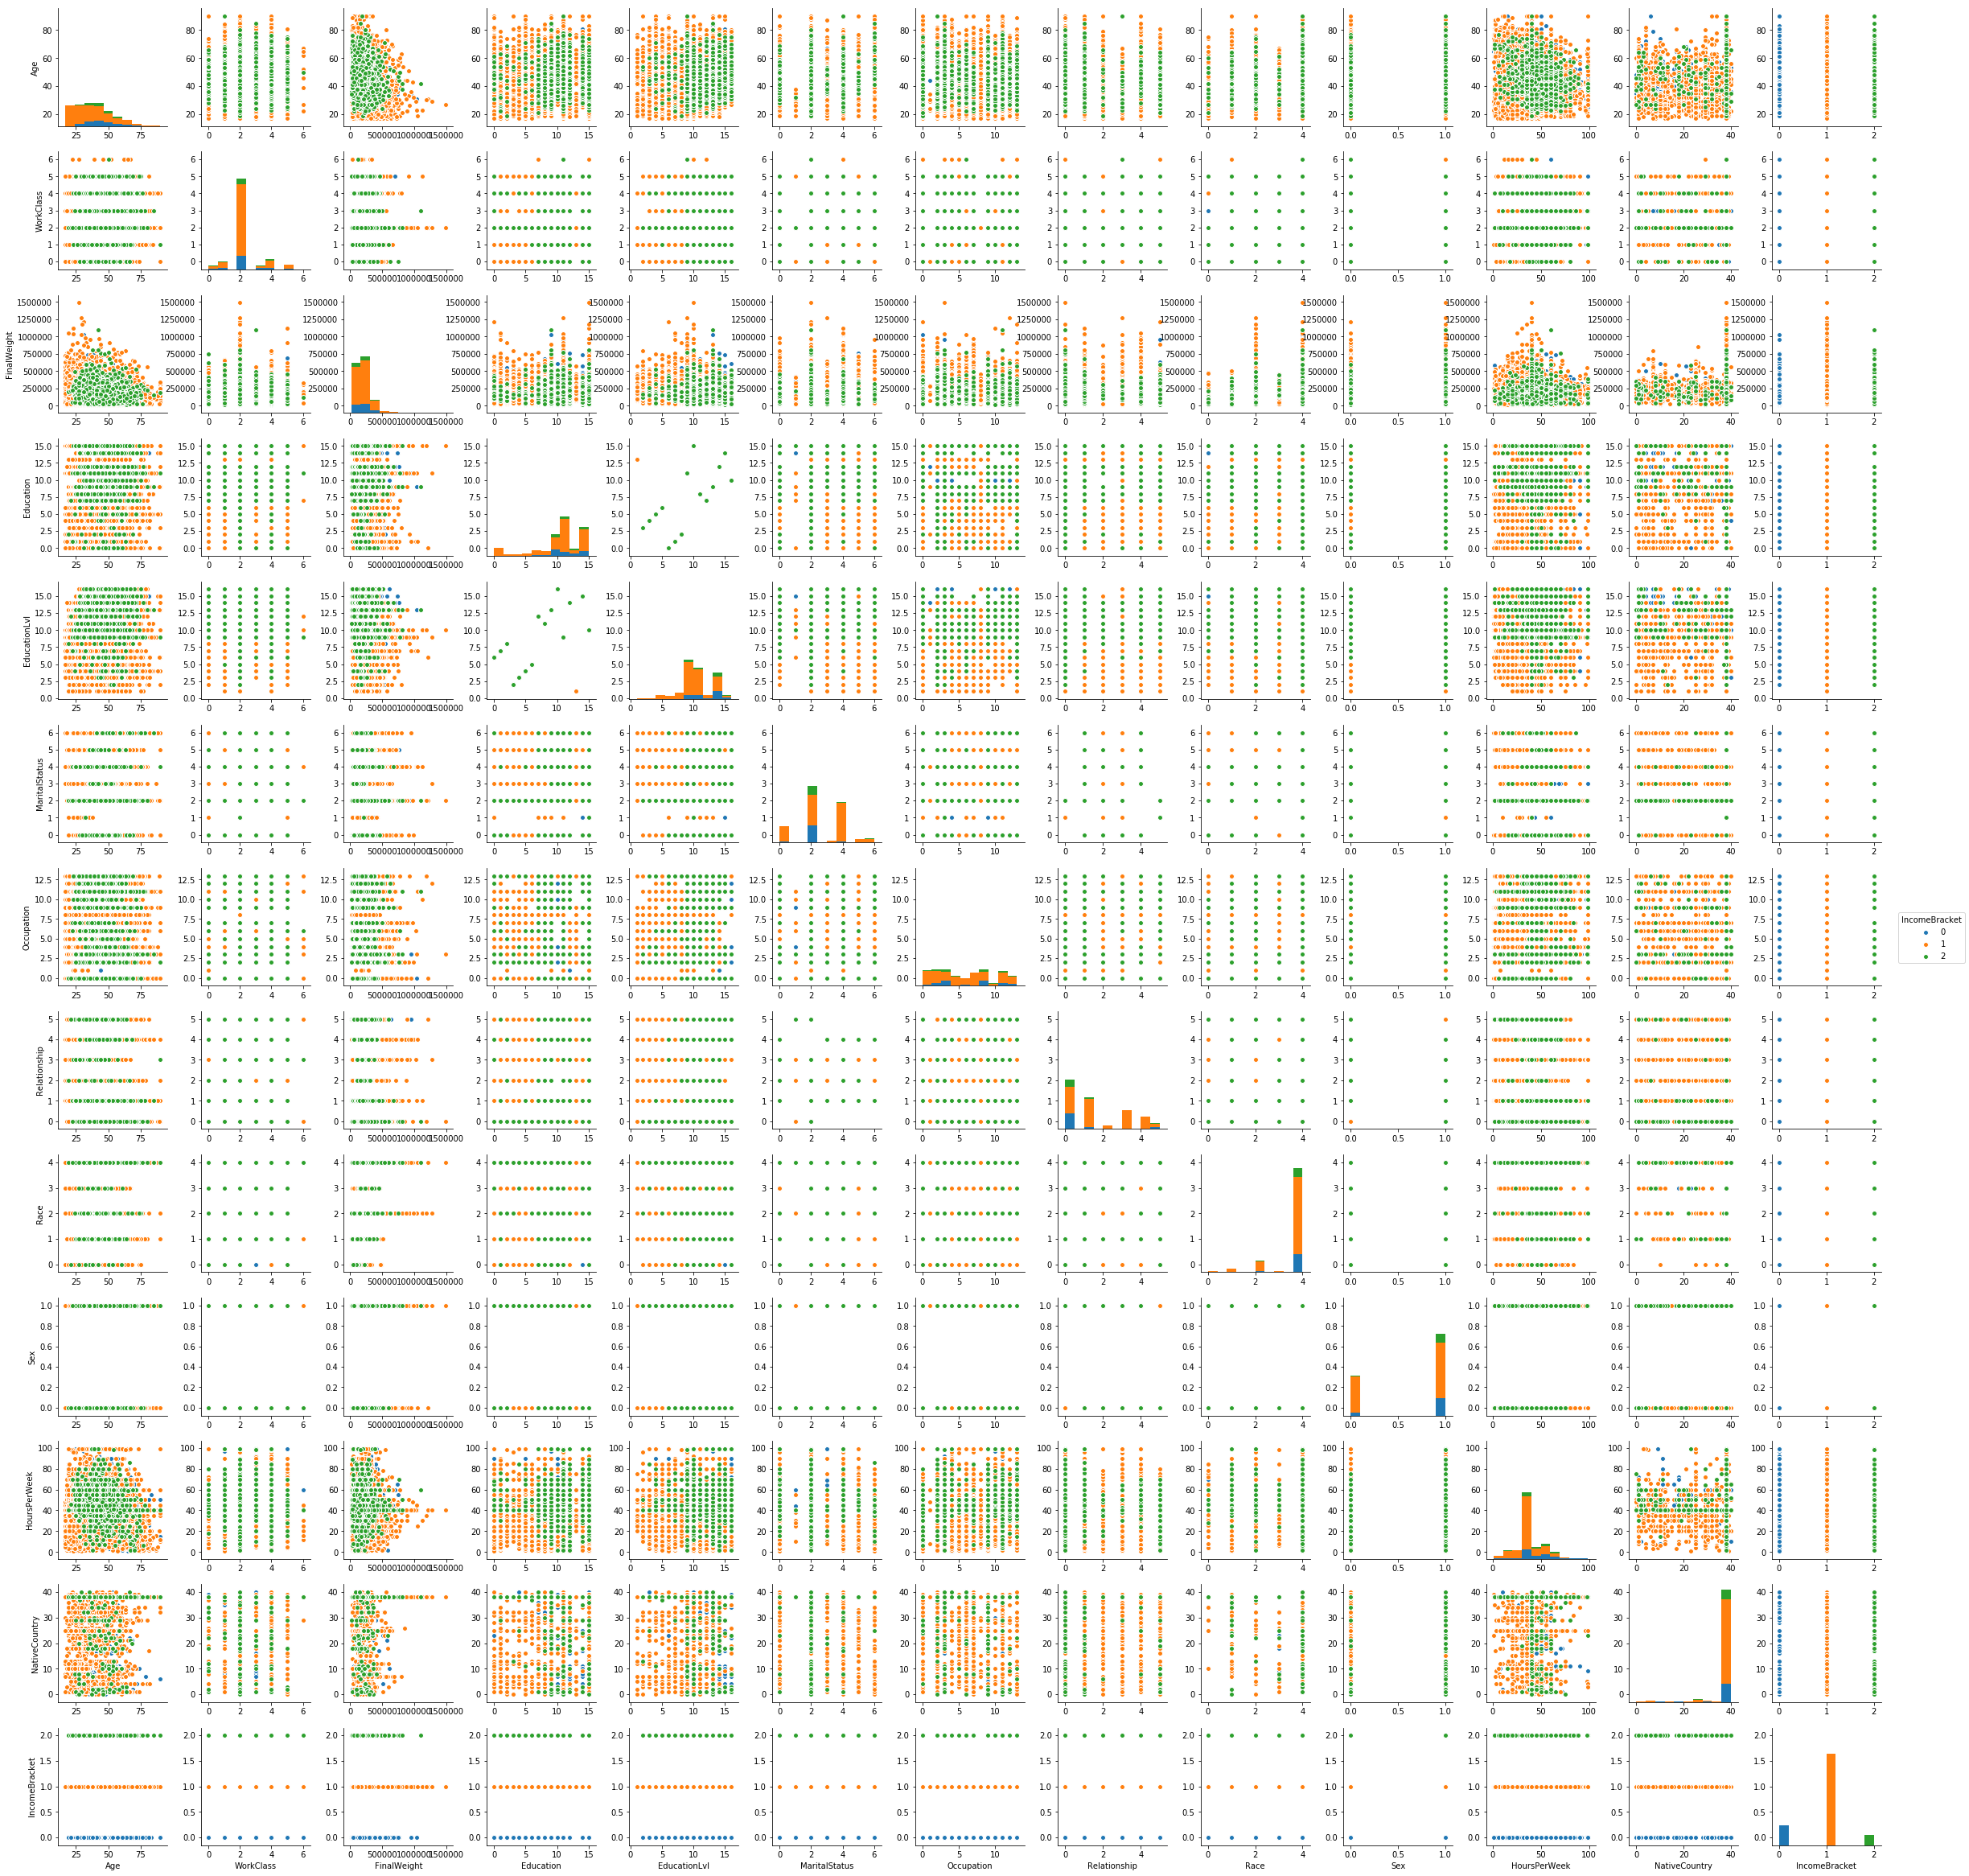

In [352]:
plt.figure()
sns.pairplot(training_df,hue='IncomeBracket')

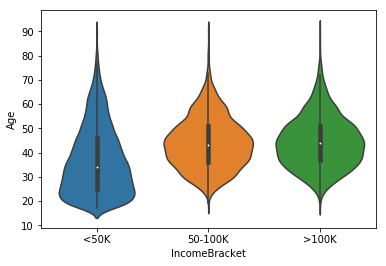

In [353]:
sns.violinplot(x="IncomeBracket", y="Age", data=unencodedtraining)

### The above violin plot clearly shows the age is strong factor effecting the income bracket becasue the distributions differ across all age groups. People with higher age have more salary so they are lower in numbers in <50K bracket

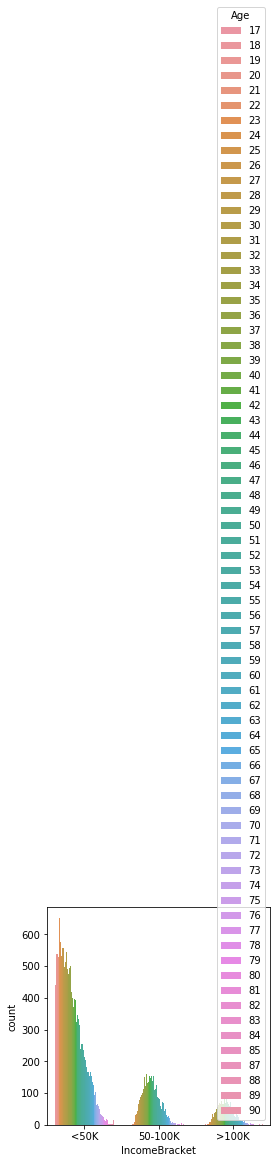

In [378]:
plt.figure(figsize = (4,4))
sns.countplot(x='IncomeBracket', hue="Age", data=unencodedtraining, orient= "h")

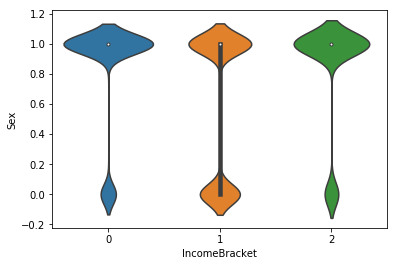

In [363]:
sns.violinplot(x="IncomeBracket", y="Sex", data=training_df)

### The above plot shows sex is not a feature effecting the income distribution becasue it is same acrooss the the brackets

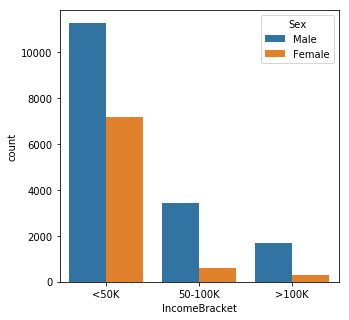

In [377]:
plt.figure(figsize = (5,5))
sns.countplot(x='IncomeBracket', hue="Sex", data=unencodedtraining)

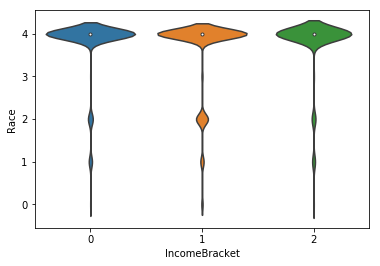

In [369]:
sns.violinplot(x="IncomeBracket", y="Race", data=training_df)

### The above plot shows Race is not a feature effecting the income distribution becasue it is same acrooss the the brackets

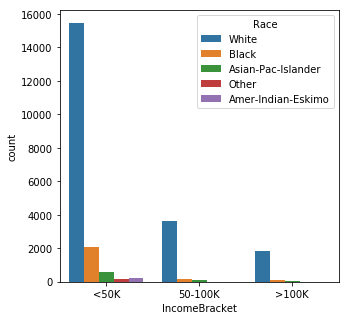

In [375]:
plt.figure(figsize = (5,5))
sns.countplot(x='IncomeBracket', hue="Race", data=unencodedtraining)

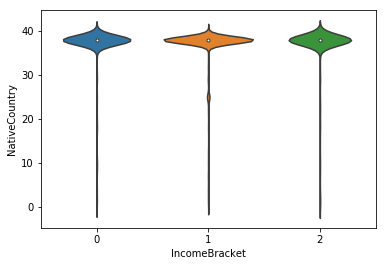

In [372]:
sns.violinplot(x="IncomeBracket", y="NativeCountry", data=training_df)

### The above plot shows Nativecountry is not a feature effecting the income distribution becasue it is same acrooss the the brackets

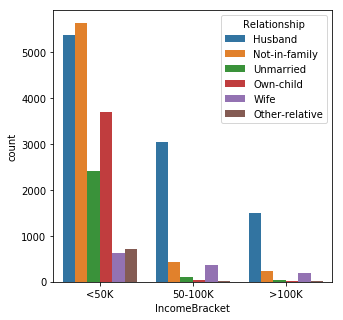

In [376]:
plt.figure(figsize = (5,5))
sns.countplot(x='IncomeBracket', hue="Relationship", data=unencodedtraining)

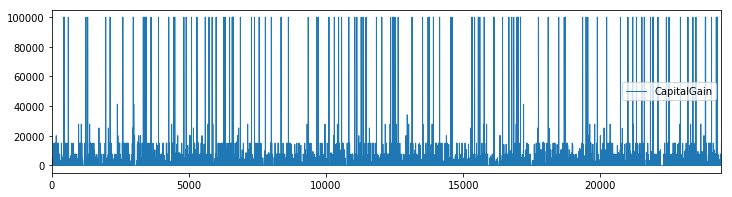

In [412]:
training_df.plot.line(x=training_df.index,y='CapitalGain',figsize=(12,3),lw=1)


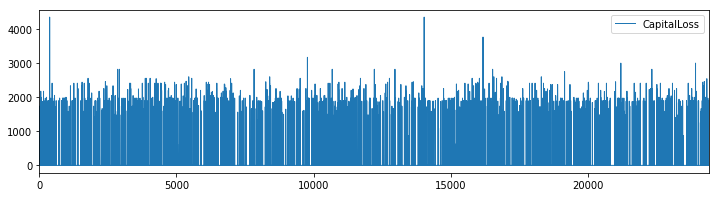

In [414]:
training_df.plot.line(x=training_df.index,y='CapitalLoss',figsize=(12,3),lw=1)

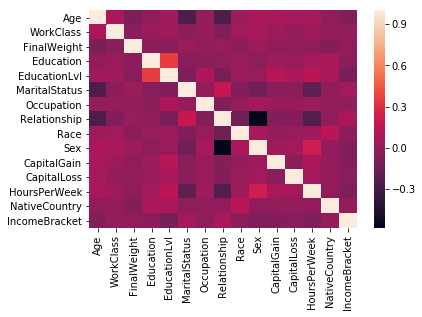

In [415]:
sns.heatmap(training_df.corr())

### The heat map gives us a basic idea of correlation

## PART 3: Feature Enigneering

#### Feature enigneering has many benefits
1. Increases the flexibility of the model, less the features more faster is the algorithm. This is illustrated below with an example
2. simpler models because, thee model is less biased and more accurate on unseen data
3. Most of the accuracy of the models not on the complexity but on the features used

### Creating New Features

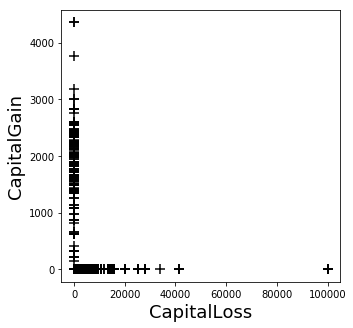

In [419]:
figure_2 = plt.figure(figsize = (5,5))
plt.scatter(training_df['CapitalGain'],training_df['CapitalLoss'],marker = '+', color = 'k', s = 100)
plt.ylabel('CapitalGain', fontsize = 18)
plt.xlabel('CapitalLoss', fontsize = 18)
plt.show()

#### we can see that for all CapitalLoss values the Capital Gain is zero and for all Capital Gain values Capital Loss is zero, this means that a person has either only capital loss or capial gain so I combined both of them in to a single feature for this I subtracted Loss from Gain.

In [23]:
training_df['CapitalLoss/Gain'] = training_df['CapitalGain'] - training_df['CapitalLoss']

In [452]:
training_df.head()

,Age,WorkClass,FinalWeight,Education,EducationLvl,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,IncomeBracket,CapitalLoss/Gain
0,42,5,179151,15,10,2,4,0,4,1,0,0,40,38,1,0
1,28,2,68021,15,10,4,7,1,4,0,0,0,30,38,1,0
2,24,2,233499,15,10,2,13,0,4,1,0,0,40,38,0,0
3,32,4,168782,6,5,2,2,0,4,1,0,0,32,38,1,0
4,55,4,105582,12,14,2,11,0,4,1,2228,0,50,38,1,2228


In [24]:
training_df = training_df.drop(['CapitalGain','CapitalLoss'],axis = 1)

### Feature Importance from models

To measure feature importance I am using two classifiers, The model algorithms will be explained in detailed in later sections

In [25]:
X = training_df.drop(['IncomeBracket'], axis=1)
y = training_df.IncomeBracket
df = X.copy()
sc = StandardScaler()
sc.fit(X)
X = sc.transform(X)
X_train_std, X_test_std, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.3)

In [455]:
dt = DecisionTreeClassifier()
dt.fit(X_train_std,y_train)
y_pred = dt.predict(X_test_std)
y_pred_Train = dt.predict(X_train_std)

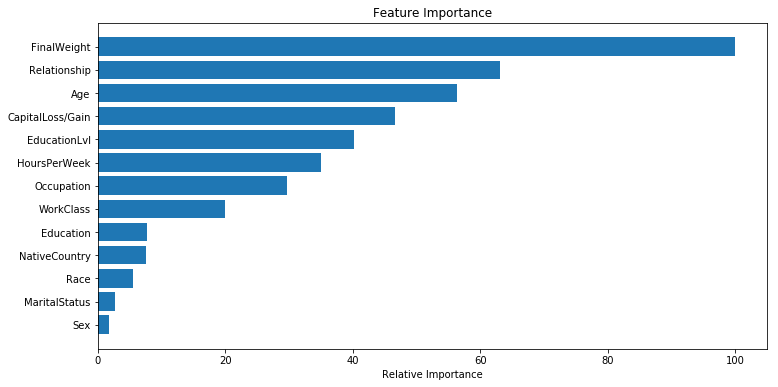

In [456]:
# plotting feature importance
feature_importance = dt.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(12, 6))
plt.subplot(1, 1, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
plt.show()

In [457]:
rfc = RandomForestClassifier()
rfc.fit(X_train_std,y_train)
y_pred = rfc.predict(X_test_std)
y_pred_Train = rfc.predict(X_train_std)

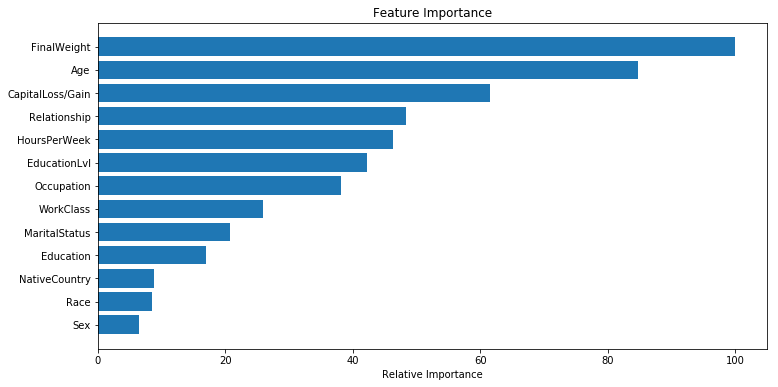

In [458]:
# plotting feature importance
# df = training_df.drop(['IncomeBracket'],1)
feature_importance = rfc.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(12, 6))
plt.subplot(1, 1, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
plt.show()

### Removing features as infered from plots above the Race, sex and native country are  equally related to income bracket so it is better to remove them, but before doing this I am will run a simple Gboost classifier on the data with default parametets and compare the computational time before and after the features are removed. The models willl be explained clearly in bottom sections

#### Before removing features

In [423]:
# X = training_df.drop(['IncomeBracket'], axis=1)
# y = training_df.IncomeBracket
# df = X.copy()
# sc = StandardScaler()
# sc.fit(X)
# X = sc.transform(X)
# X_train_std, X_test_std, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.3)


In [459]:
%%time
gbc = GradientBoostingClassifier()
gbc.fit(X_train_std,y_train)
y_pred = gbc.predict(X_test_std)
y_pred_Train = gbc.predict(X_train_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy Train: %.4f' % accuracy_score(y_train, y_pred_Train))
print('Accuracy Test: %.4f' % accuracy_score(y_test, y_pred))
scores = cross_val_score(gbc,X,y, cv=10)
print("cross validation scores")
print(scores)
print("mean and std : %0.4f %0.4f" % (scores.mean(), scores.std()))

Misclassified samples: 1352
Accuracy Train: 0.8243
Accuracy Test: 0.8155
cross validation scores
[ 0.81301146  0.81996727  0.81669394  0.81498158  0.81360098  0.81155264
  0.81523966  0.81319132  0.81605899  0.81032364]
mean and std : 0.8145 0.0026
Wall time: 46.7 s


### After removing the features

In [26]:
training_df = training_df.drop(['Race','Sex','NativeCountry'],axis = 1)

In [27]:
X = training_df.drop(['IncomeBracket'], axis=1)
y = training_df.IncomeBracket
df = X.copy()
sc = StandardScaler()
sc.fit(X)
X = sc.transform(X)
X_train_std, X_test_std, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.3)

In [462]:
%%time
gbc = GradientBoostingClassifier()
gbc.fit(X_train_std,y_train)
y_pred = gbc.predict(X_test_std)
y_pred_Train = gbc.predict(X_train_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy Train: %.4f' % accuracy_score(y_train, y_pred_Train))
print('Accuracy Test: %.4f' % accuracy_score(y_test, y_pred))
scores = cross_val_score(gbc,X,y, cv=10)
print("cross validation scores")
print(scores)
print("mean and std : %0.4f %0.4f" % (scores.mean(), scores.std()))

Misclassified samples: 1351
Accuracy Train: 0.8246
Accuracy Test: 0.8156
cross validation scores
[ 0.81342062  0.81873977  0.81628478  0.81457225  0.81360098  0.81114297
  0.81564932  0.81360098  0.81646866  0.81319132]
mean and std : 0.8147 0.0020
Wall time: 40.5 s


#### we can see that the time has decreased  by 6 seconds or 10% decrease in time with only reducing three features. 
#### Due to this reason I removed the less imporant features "Race", "sex", "Nativecountry" and also used label encodet instead of dummies 
#### It can be argued that this decrease changes according to the computer power and can be neglible in other computers but, in real world data analysis we often get huge amounts of data which requires high memory power so it is still always better to reduce features


## PART 4: Model Implementation

### Five models have been implemented and for each of them following parameters are calculated
1. Accuracy Train: Train Accuracy, on 70% of training data
2. Accuray test : Test accuracy on 30% of testing data
3. cross validation scores of 10 folds, this is performed on whole training data
4. mean and standard deviation for 1o cross validation scores

In [ ]:
# X = training_df.drop(['IncomeBracket'], axis=1)
# y = training_df.IncomeBracket
# df = X.copy()
# sc = StandardScaler()
# sc.fit(X)
# X = sc.transform(X)
# X_train_std, X_test_std, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.3)

### As the data is already split in above section, the above cell is commented
I am using standard scalar to normalize the data because of not giving importance to any column because it is having high numerical values. 
### normalization using standard scalar is important, all the models below have been tested with out standard scalat and in all of the casses it is observed that models performed slighlty around 1% more accurate on the normalized data using standard scalar.

#### Logistic regression

In [463]:
lr = LogisticRegression(class_weight='balanced', multi_class='multinomial', solver='lbfgs')
lr.fit(X_train_std,y_train)
y_pred = lr.predict(X_test_std)
y_pred_Train = lr.predict(X_train_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy Train: %.4f' % accuracy_score(y_train, y_pred_Train))
print('Accuracy Test: %.4f' % accuracy_score(y_test, y_pred))
scores = cross_val_score(lr,X,y, cv=10)
print("cross validation scores")
print(scores)
print("mean and std : %0.4f %0.4f" % (scores.mean(), scores.std()))

Misclassified samples: 2474
Accuracy Train: 0.6568
Accuracy Test: 0.6623
cross validation scores
[ 0.64729951  0.6497545   0.65384615  0.66680311  0.64891438  0.65424007
  0.6640721   0.6628431   0.65342073  0.6460467 ]
mean and std : 0.6547 0.0070


In [464]:
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(y_pred, return_counts=True)
print(dict(zip(unique, counts)))

{0: 2795, 1: 12881, 2: 1418}
{0: 1644, 1: 4518, 2: 1165}


### Random forest classfier

In [467]:
rfc = RandomForestClassifier()
rfc.fit(X_train_std,y_train)
y_pred = rfc.predict(X_test_std)
y_pred_Train = rfc.predict(X_train_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy Train: %.4f' % accuracy_score(y_train, y_pred_Train))
print('Accuracy Test: %.4f' % accuracy_score(y_test, y_pred))
scores = cross_val_score(rfc,X,y, cv=10)
print("cross validation scores")
print(scores)
print("mean and std : %0.4f %0.4f" % (scores.mean(), scores.std()))

Misclassified samples: 1626
Accuracy Train: 0.9874
Accuracy Test: 0.7781
cross validation scores
[ 0.76923077  0.79091653  0.78518822  0.78100696  0.7824662   0.78820156
  0.78369521  0.78943056  0.79393691  0.7812372 ]
mean and std : 0.7845 0.0066


In [468]:
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(y_pred, return_counts=True)
print(dict(zip(unique, counts)))

{0: 2795, 1: 12881, 2: 1418}
{0: 1249, 1: 5834, 2: 244}


### KNN classifier

In [469]:
knn = KNeighborsClassifier()
knn.fit(X_train_std,y_train)
y_pred = knn.predict(X_test_std)
y_pred_Train = knn.predict(X_train_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy Train: %.4f' % accuracy_score(y_train, y_pred_Train))
print('Accuracy Test: %.4f' % accuracy_score(y_test, y_pred))
scores = cross_val_score(knn,X,y, cv=10)
print("cross validation scores")
print(scores)
print("mean and std : %0.4f %0.4f" % (scores.mean(), scores.std()))

Misclassified samples: 1627
Accuracy Train: 0.8316
Accuracy Test: 0.7779
cross validation scores
[ 0.76432079  0.77373159  0.77454992  0.77568563  0.78533388  0.76853748
  0.78164687  0.78533388  0.78492421  0.77140516]
mean and std : 0.7765 0.0071


In [472]:
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(y_pred, return_counts=True)
print(dict(zip(unique, counts)))

{0: 2795, 1: 12881, 2: 1418}
{0: 1224, 1: 5480, 2: 623}


#### Decision tree

In [473]:
dt = DecisionTreeClassifier()
dt.fit(X_train_std,y_train)
y_pred = dt.predict(X_test_std)
y_pred_Train = dt.predict(X_train_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy Train: %.4f' % accuracy_score(y_train, y_pred_Train))
print('Accuracy Test: %.4f' % accuracy_score(y_test, y_pred))
scores = cross_val_score(dt,X,y, cv=10)
print("cross validation scores")
print(scores)
print("mean and std : %0.4f %0.4f" % (scores.mean(), scores.std()))

Misclassified samples: 1932
Accuracy Train: 1.0000
Accuracy Test: 0.7363
cross validation scores
[ 0.72585925  0.73731588  0.73977087  0.73679902  0.74190905  0.74068005
  0.73371569  0.73945104  0.74068005  0.7361737 ]
mean and std : 0.7372 0.0045


In [474]:
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(y_pred, return_counts=True)
print(dict(zip(unique, counts)))

{0: 2795, 1: 12881, 2: 1418}
{0: 1213, 1: 5481, 2: 633}


#### Gradient Boosting 

In [635]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train_std,y_train)
y_pred = gbc.predict(X_test_std)
y_pred_Train = gbc.predict(X_train_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy Train: %.4f' % accuracy_score(y_train, y_pred_Train))
print('Accuracy Test: %.4f' % accuracy_score(y_test, y_pred))
scores = cross_val_score(gbc,X,y, cv=10)
print("cross validation scores")
print(scores)
print("mean and std : %0.4f %0.4f" % (scores.mean(), scores.std()))

Misclassified samples: 1350
Accuracy Train: 0.8246
Accuracy Test: 0.8157
cross validation scores
[ 0.81505728  0.81751227  0.81792144  0.81293492  0.81401065  0.81114297
  0.81442032  0.81360098  0.81646866  0.81237198]
mean and std : 0.8145 0.0021


In [217]:
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(y_pred, return_counts=True)
print(dict(zip(unique, counts)))

## Model selection 

1. All the models have been performed using default parameters only

The following are the mean accuracy and standard deviation across 10 folds for the models.

Logistic : 0.6547, 0.0070

Random Forest: 0.7845, 0.0066

KNN : 0.7765, 0.0071

Decision Tree: 0.7372, 0.0045

Gboost : 0.8145, 0.0021

2. Logistic regression perforem worse with low accuracy and high variance,
3. Gboost performed the best with high model accurayc and low variance
4. Both Random forest and Gboost performed better than decision tree indicating ensemble methods have better accuracy.
5. One of the reasons for Gradient boost performing better is because of its nature of reducing error in sequences and it's robust ness towards overfitting
6. Gradient boosting performing better than radom forests may imply that the model is overggit or the data is not sufficient enough for random forests to overcome its disadvanatage of not being able to reduce bias. 
7. Decisionn trees performing bettter than logistic regression implies that the dimensionality is too large for loogistic regresssion to handle and also the data may not have clear decision boundaries which is necessary for loogistic regression to perform well


### Gradient boosting algorithm is selected furthur to tune because of the reasons exxplained above

## Part 5: Model Tuning

#### Gradient booster has many hyperparameters to tune but we considered for this assingment a few important ones.

In [29]:
def GradientBooster(param_grid): 
    estimator = GradientBoostingClassifier() 
    classifier = GridSearchCV(estimator=estimator, cv=10, param_grid=param_grid) 
    classifier.fit(X,y)
    print("Best Estimator learned through GridSearch")
    print(classifier.best_estimator_)    
    print(classifier.grid_scores_)
    print(classifier.best_score_)
    return classifier.best_estimator_

In [31]:
# param_grid={'n_estimators': [100,125], 'learning_rate': [0.05,0.1,0.15], 'max_depth':[3,5,6], 'min_samples_split':[2, 100]}
# best_est=GradientBooster(param_grid)  

The above mentioned ranges are used for hyper parameter tuning. As it is taking more time to run the above for simplicity I am chaning one at a time to describe the optimal parameters

In [34]:
param_grid={'n_estimators': [100,125], 'learning_rate': [0.1], 'max_depth':[3], 'min_samples_split':[2]}
best_est=GradientBooster(param_grid)  

Best Estimator learned through GridSearch
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=125,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
[mean: 0.81475, std: 0.00289, params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}, mean: 0.81545, std: 0.00281, params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 125}]
0.815445722943


C:\Users\Naga Raja Paidimarri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


#### n_etimators 125 is better than n_estimators 100

In [35]:
param_grid={'n_estimators': [125], 'learning_rate': [0.1], 'max_depth':[2,3], 'min_samples_split':[2]}
best_est=GradientBooster(param_grid)  

Best Estimator learned through GridSearch
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=125,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
[mean: 0.81139, std: 0.00264, params: {'learning_rate': 0.1, 'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 125}, mean: 0.81528, std: 0.00267, params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 125}]
0.815281929487


C:\Users\Naga Raja Paidimarri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


#### max_depth 3 is better than 2

The above hyperparameters have been tuned for small ranges, the final best values are obtained

In [636]:
param_grid={'n_estimators': [125], 'learning_rate': [0.1], 'max_depth':[3], 'min_samples_split':[2]}
best_est=GradientBooster(param_grid)  

Best Estimator learned through GridSearch
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=125,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
[mean: 0.81569, std: 0.00248, params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 125}]
0.815691413128


C:\Users\Naga Raja Paidimarri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [637]:
print("Best Estimator Parameters")
print("---------------------------")
print("n_estimators: %d" %best_est.n_estimators)
print("max_depth: %d" %best_est.max_depth)
print("learning_rate: %.1f" %best_est.learning_rate)
print("min_samples_leaf: %d" %best_est.min_samples_leaf)
# print("max_features: %.1f" %best_est.max_features)
print("Accuracy: %.2f" %best_est.score(X_train_std,y_train))
# scores = cross_val_score(best_est,X,y, cv=10)
# print("cross validation scores")
# print(scores)
# print("mean and std : %0.4f %0.4f" % (scores.mean(), scores.std()))

Best Estimator Parameters
---------------------------
n_estimators: 125
max_depth: 3
learning_rate: 0.1
min_samples_leaf: 1
Accuracy: 0.82


## The model accuracy has been increase from 81.45 to 81.56 %. The parameters changed are mentioned above.

## PART 6: Testing the model on testing data

In [566]:
testing_df = pd.read_csv('income-testing.csv')

In [567]:
testing_df.head()

,Age,WorkClass,FinalWeight,Education,EducationLvl,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,IncomeBracket
0,57,Self-emp-not-inc,152030,Some-college,10,Married-civ-spouse,Sales,Wife,White,Female,0,0,25,United-States,50-100K
1,35,Private,341643,Bachelors,13,Never-married,Other-service,Other-relative,White,Male,0,0,50,United-States,<50K
2,26,Private,40915,Bachelors,13,Never-married,Other-service,Not-in-family,White,Female,0,0,25,United-States,<50K
3,27,Federal-gov,257124,Bachelors,13,Never-married,Transport-moving,Other-relative,White,Male,0,0,35,United-States,<50K
4,21,Private,256278,HS-grad,9,Never-married,Other-service,Other-relative,Other,Female,0,0,35,El-Salvador,<50K


In [568]:
testing_df.isnull().sum()

Age                0
WorkClass        688
FinalWeight        0
Education          0
EducationLvl       0
MaritalStatus      0
Occupation       690
Relationship       0
Race               0
Sex                0
CapitalGain        0
CapitalLoss        0
HoursPerWeek       0
NativeCountry    225
IncomeBracket      0
dtype: int64

In [569]:
testing_df["WorkClass"].value_counts()

Private             8426
Self-emp-not-inc     989
Local-gov            792
State-gov            488
Self-emp-inc         444
Federal-gov          378
Without-pay            4
Never-worked           2
Name: WorkClass, dtype: int64

In [570]:
testing_df["Occupation"].value_counts()

Exec-managerial      1560
Craft-repair         1541
Prof-specialty       1540
Sales                1377
Adm-clerical         1353
Other-service        1221
Machine-op-inspct     742
Transport-moving      620
Handlers-cleaners     494
Farming-fishing       391
Tech-support          359
Protective-serv       247
Priv-house-serv        72
Armed-Forces            4
Name: Occupation, dtype: int64

In [571]:
testing_df["NativeCountry"].value_counts()

United-States                 11003
Mexico                          206
Philippines                      68
Germany                          59
Canada                           51
Puerto-Rico                      46
India                            34
Cuba                             33
China                            33
El-Salvador                      31
England                          31
Italy                            30
Dominican-Republic               29
Jamaica                          28
Guatemala                        26
South                            24
Portugal                         21
Nicaragua                        19
Japan                            18
Haiti                            18
Vietnam                          17
Columbia                         17
Iran                             13
Peru                             13
Taiwan                           12
Ecuador                          12
Poland                           11
Greece                      

In [572]:
df1 = testing_df[testing_df.WorkClass.isnull()] 
df2 = testing_df[testing_df.Occupation.isnull()] 
df3 = testing_df[testing_df.NativeCountry.isnull()] 
new_df_test = pd.concat([df1,df2,df3],axis =0)

In [573]:
new_df_train = pd.concat([testing_df, new_df_test]).drop_duplicates(keep=False)

In [574]:
new_df_test = new_df_test.drop(['WorkClass','Occupation', 'NativeCountry'],1)
new_df_train.isnull().sum()
new_df_test = new_df_test.drop_duplicates()
x = new_df_train.copy()

In [575]:
le = preprocessing.LabelEncoder()
for col_name in new_df_train.columns:
    if(new_df_train[col_name].dtype == 'object'):
        le.fit(new_df_train[col_name])
        new_df_train[col_name] = le.transform(new_df_train[col_name]) 

In [576]:
le = preprocessing.LabelEncoder()
for col_name in new_df_test.columns:
    if(new_df_test[col_name].dtype == 'object'):
        le.fit(new_df_test[col_name])
        new_df_test[col_name] = le.transform(new_df_test[col_name]) 

In [577]:
X_train = new_df_train.drop(['WorkClass','Occupation', 'NativeCountry','IncomeBracket'],1)
y_train = new_df_train.WorkClass
X_test = new_df_test.drop(['IncomeBracket'],1)
indexlist = new_df_test.index.values

In [578]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)
y_pred_Train = rfc.predict(X_train)
print('Accuracy: %.4f' % accuracy_score(y_train, y_pred_Train))

le = preprocessing.LabelEncoder()
le.fit(x['WorkClass'])
y_pred_inverse = le.inverse_transform(y_pred)

for i in range (0,len(indexlist)):
    testing_df.iloc[indexlist[i],1] = y_pred_inverse[i]

Accuracy: 0.9733


In [579]:
y_train = new_df_train.Occupation

rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)
y_pred_Train = rfc.predict(X_train)
print('Accuracy: %.4f' % accuracy_score(y_train, y_pred_Train))

le = preprocessing.LabelEncoder()
le.fit(x['Occupation'])
y_pred_inverse = le.inverse_transform(y_pred)

for i in range (0,len(indexlist)):
    testing_df.iloc[indexlist[i],6] = y_pred_inverse[i]

Accuracy: 0.9717


In [580]:
y_train = new_df_train.NativeCountry

rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)
y_pred_Train = rfc.predict(X_train)
print('Accuracy: %.4f' % accuracy_score(y_train, y_pred_Train))

le = preprocessing.LabelEncoder()
le.fit(x['NativeCountry'])
y_pred_inverse = le.inverse_transform(y_pred)

for i in range (0,len(indexlist)):
    testing_df.iloc[indexlist[i],13] = y_pred_inverse[i]

Accuracy: 0.9940


In [581]:
testing_df.isnull().sum()

Age              0
WorkClass        0
FinalWeight      0
Education        0
EducationLvl     0
MaritalStatus    0
Occupation       0
Relationship     0
Race             0
Sex              0
CapitalGain      0
CapitalLoss      0
HoursPerWeek     0
NativeCountry    0
IncomeBracket    0
dtype: int64

In [582]:
testing_df

,Age,WorkClass,FinalWeight,Education,EducationLvl,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,IncomeBracket
0,57,Self-emp-not-inc,152030,Some-college,10,Married-civ-spouse,Sales,Wife,White,Female,0,0,25,United-States,50-100K
1,35,Private,341643,Bachelors,13,Never-married,Other-service,Other-relative,White,Male,0,0,50,United-States,<50K
2,26,Private,40915,Bachelors,13,Never-married,Other-service,Not-in-family,White,Female,0,0,25,United-States,<50K
3,27,Federal-gov,257124,Bachelors,13,Never-married,Transport-moving,Other-relative,White,Male,0,0,35,United-States,<50K
4,21,Private,256278,HS-grad,9,Never-married,Other-service,Other-relative,Other,Female,0,0,35,El-Salvador,<50K
5,28,Private,128055,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,60,United-States,<50K
6,34,Private,303187,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Asian-Pac-Islander,Male,0,0,40,Philippines,>100K
7,26,Private,205109,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,40,United-States,<50K
8,26,Private,33610,HS-grad,9,Never-married,Transport-moving,Own-child,White,Male,0,0,40,United-States,<50K
9,35,State-gov,167482,HS-grad,9,Never-married,Protective-serv,Own-child,White,Male,0,1980,40,United-States,<50K


In [583]:
le = preprocessing.LabelEncoder()
for col_name in testing_df.columns:
    if(testing_df[col_name].dtype == 'object'):
        le.fit(testing_df[col_name])
        testing_df[col_name] = le.transform(testing_df[col_name]) 

In [584]:
testing_df['CapitalLoss/Gain'] = testing_df['CapitalGain'] - testing_df['CapitalLoss']

In [585]:
testing_df = testing_df.drop(['CapitalGain','CapitalLoss'],axis = 1)

In [586]:
testing_df = testing_df.drop(['Race','Sex','NativeCountry'],axis = 1)

In [587]:
X = testing_df.drop(['IncomeBracket'], axis=1)
y = testing_df.IncomeBracket
df = X.copy()
sc = StandardScaler()
sc.fit(X)
X = sc.transform(X)

In [588]:
y_pred = best_est.predict(X)
print('Accuracy Test: %.4f' % accuracy_score(y, y_pred))
scores = cross_val_score(best_est,X,y, cv=10)
print("cross validation scores")
print(scores)
print("mean and std : %0.4f %0.4f" % (scores.mean(), scores.std()))

Accuracy Test: 0.7964
cross validation scores
[ 0.79067866  0.79721995  0.80784955  0.7968878   0.81244881  0.80409836
  0.79590164  0.80737705  0.8057377   0.80245902]
mean and std : 0.8021 0.0064


### Discussion 

1. The accuracy on testing data is slighlty less than training data around 1%.
2. But the cross validation variance is still less
3. The model tuned is perfectly fit, neither over fit nor under fit.
4. THe accuracy is only slightly less indicates the model is neither biased nor high variance. indicating the tuned parameters are correct and also the Gboost model is the best for this data

### Comparision of different models. 

Logistic regression
I choose this becasue it is easy to implement
pros:
1. easy to implement and train. It works very fast computationally than other alogrithms. we can check this while we run our code.
Cons:
1. In case of multiple decision boundaries the logisitic regression fails badly because it only can seperate by linear boundaries. IN our case we have three income classes to predict so the model performs very poorly.


KNN classifier
After I found logistic regression giving low accuracies I used KNN classifier. becasue it is also relatively simple in comparision to ensemble algorithms
pros:
1. Simple to implement and can predict multiple classes. IN our case it did work well in predicting multiple income brackets.
cons:
1. changes the prediction by K value. It takes lot of tuning to find the perfect k value. 

Decision trees
After working on both knn and logistic regression I noticed that number of features are very high so I wanted to check the applicability of decision trees
pros:
1. Ability to selecting most important features
cons:
1. can easily overfit the data. this happens to be the case here. THe cross validation accuarcy of decision trees is less than knn algorithm

Random forest
I wanted to use advanced classification algorithms to see if they can improve on accuracy
pros:
1.Pros
it reduces the overfitting relative to decision trees and also deal with correalted features well. This is the reason the accuracy in our case 78% higheer than deicison trees
1. cons 
we cannot visually interpret the results.

Gbooting
this is another popular ensemble algorithms.
Pros
1. based on weak leaners so even though it takes time to learn the result is better than random forests. in this case it takes the maximum time to run this but the accuracy obtained is also the maximum.
Cons
1. we cannot visually interpret the results.